Date
2020-08-24 00:00:00-04:00         NaN
2020-08-25 00:00:00-04:00         NaN
2020-08-26 00:00:00-04:00         NaN
2020-08-27 00:00:00-04:00         NaN
2020-08-28 00:00:00-04:00         NaN
                               ...   
2025-08-18 00:00:00-04:00    0.229131
2025-08-19 00:00:00-04:00    0.227665
2025-08-20 00:00:00-04:00    0.211492
2025-08-21 00:00:00-04:00    0.206704
2025-08-22 00:00:00-04:00    0.192177
Name: rvol_5d, Length: 1256, dtype: float64
Date
2020-08-24 00:00:00-04:00         NaN
2020-08-25 00:00:00-04:00         NaN
2020-08-26 00:00:00-04:00         NaN
2020-08-27 00:00:00-04:00         NaN
2020-08-28 00:00:00-04:00         NaN
                               ...   
2025-08-18 00:00:00-04:00    0.243500
2025-08-19 00:00:00-04:00    0.217355
2025-08-20 00:00:00-04:00    0.219725
2025-08-21 00:00:00-04:00    0.205484
2025-08-22 00:00:00-04:00    0.202637
Name: rvol_6d, Length: 1256, dtype: float64
Date
2020-08-24 00:00:00-04:00         NaN
2020-08-25 00:00:00-04:

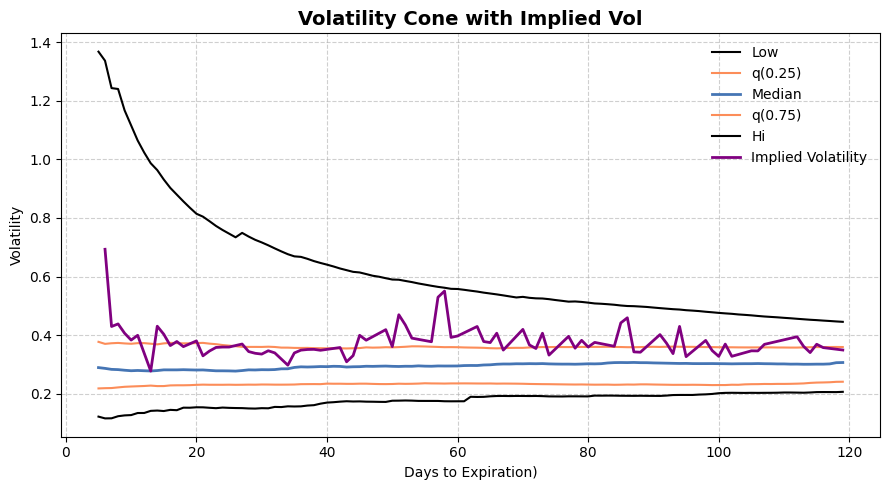

<Axes: title={'center': 'Volatility Cone with Implied Vol'}, xlabel='Days to Expiration)', ylabel='Volatility'>

In [7]:
import sys, pandas as pd, numpy as np, yfinance as yf, importlib
sys.path.append("../src")

import vol_cone
importlib.reload(vol_cone)
df1 = pd.read_csv("../data/aapl_eod_202303.csv")
ticker = yf.Ticker("AAPL")
df2 = ticker.history(period="60mo")

#windows = [20, 40, 60, 120, 240]
windows = tuple(range(5, 120))
summary = vol_cone.five_n_sum(df2, windows=windows, T = 242)

iv_curve = vol_cone.iv_curve_from_snapshot(df1)

# Plot with IV overlay
vol_cone.plot_realized_vol_cone(
    summary,
    title="Volatility Cone with Implied Vol",
    iv_curve=iv_curve
)


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                    Low   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5675.26
Distribution:                  Normal   AIC:                           11358.5
Method:            Maximum Likelihood   BIC:                           11379.1
                                        No. Observations:                 1256
Date:                Sun, Aug 24 2025   Df Residuals:                     1255
Time:                        15:00:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           168.1063      0.527    318.735      0.000 [1.

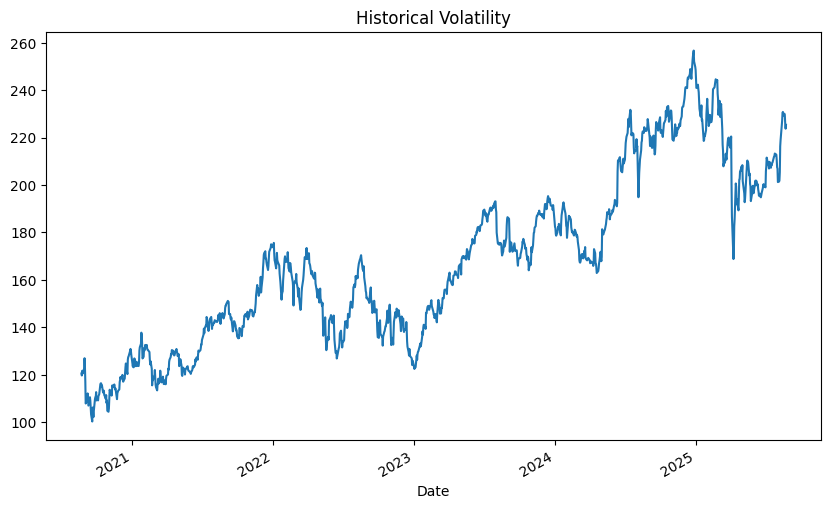

In [9]:
import sys, pandas as pd, numpy as np, yfinance as yf, importlib
from arch import arch_model
sys.path.append("../src")

import vol_cone
importlib.reload(vol_cone)
df1 = pd.read_csv("../data/aapl_eod_202303.csv")
ticker = yf.Ticker("AAPL")
df2 = ticker.history(period="60mo")
#windows = [20, 40, 60, 120, 240]
windows = tuple(range(5, 120))
# Plot log returns to visualize the data
df2.iloc[:,2].plot(title='Historical Volatility', figsize=(10, 6))

# Define the EGARCH model (1,1)
model = arch_model(df2.iloc[:,2], vol='EGARCH', p=1, q=1)

# Fit the model
egarch_fit = model.fit(disp='off')

# Print the model summary
print(egarch_fit.summary())

# Forecast volatility for the next 30 days
forecast_horizon = 30
volatility_forecast = egarch_fit.forecast(horizon=forecast_horizon,method='bootstrap')

# Extract the forecasted volatility (standard deviation) from the model
forecasted_volatility = np.sqrt(volatility_forecast.variance.values[-1, :])

# Display the forecasted volatility
print("Forecasted Volatility for the next 30 days:")
print(forecasted_volatility)

